In [1]:
#!pip3 install gillespy2
import numpy 
import gillespy2
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import numpy as np

First of all, we need to build the model using a GillesPy2 class model.

The species, the reactions (with the propensity function), the parameters of the model and the timespan for the simulation are all defined within the subclass definition.

Let's define some global variables, as:
- m: the number of simulations that are averaged to obtain the population model
- n: the size of the population
- t: the time of each simulation
- colors: the palette for the main plots

In [2]:
m = 10 #number of simulations
n = 100 #population size
t = 10000 #time
colors = numpy.array(['mediumpurple', 'mistyrose','red','green']) #palette

Now we can define some methods that will be useful to run the model, visualize the results and compare the stochastic models with the deterministic ones.

In [3]:
def run_stochastic_model(model, m, model_title, n, t = 101):
    """
    Input: a gillespy2 model, the number of trajectories to be simulated, the title of the plot
    and the number of individuals
    Output: the results of the simulation and the plot of the average value of the trajectiories
    """
    results = model.run(number_of_trajectories=m)
    #average the trajectories of the m simulations for all the 3 species
    num_species = len(model.listOfSpecies)
    average = numpy.zeros((num_species+1,t))
    for i in range(1, m+1):
        trajectory = results[i-1]
        average[0] = (i - 1) / i * average[0] + trajectory['time'] / i
        for j in range(1, (num_species+1)):
            average[j] = (i - 1) / i * average[j] + trajectory[list(model.listOfSpecies.keys())[j-1]] / i

    #plot the average trajectories
    plt.style.use("dark_background")
    for i in range(num_species):
        plt.plot(average[0], average[i+1], c = colors[i], label = list(model.listOfSpecies.keys())[i])
    plt.suptitle(model_title + ' (average of trajectories)')
    plt.title('with n = {0:d} individuals'.format(n), fontsize = 10)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('# individuals')
    return results

In [4]:
def run_deterministic_model(model, model_title, n):
    """
    Input: a gillespy2 model, the title of the plot and the number of individuals
    Output: the results of the deterministic solver and the plot of the deterministic trajectories
    """
    d_results = model.run(solver = gillespy2.solvers.numpy.ode_solver.ODESolver)
    plt.style.use("dark_background")
    num_species = len(model.listOfSpecies)
    for i in range(num_species):
        plt.plot(d_results[0]['time'], d_results[0][list(model.listOfSpecies.keys())[i]], c = colors[i], label = list(model.listOfSpecies.keys())[i])
    plt.suptitle('Deterministic ' + model_title)
    plt.title('')
    plt.legend(loc = 'best')
    plt.xlabel('time')
    plt.ylabel('# individuals')
    return d_results

In [5]:
def plot_model_trajectories(model, results, m, model_title, n):
    """
    Input: the model, the results of the simulation, the number of simulations, the title of the model, the number of individuals
    Output: a plot with all the trajectories and, for each specie, 
    the minimum, maximum and median trajectories are highlighted
    """
    plt.style.use("dark_background")
    num_species = len(model.listOfSpecies)
    sum_trajectory = np.zeros((num_species, m))
    for index in range(m):
        trajectory = results[index]
        for j in range(num_species):
            sum_trajectory[j][index] = sum(trajectory[list(model.listOfSpecies.keys())[j]])
            plt.plot(trajectory['time'], trajectory[list(model.listOfSpecies.keys())[j]], c = colors[j],  linewidth=0.5)
    
    for j in range(num_species):
        plt.plot(results[np.argmin(sum_trajectory[j,:])]['time'], results[np.argmin(sum_trajectory[j,:])][list(model.listOfSpecies.keys())[j]], c = colors[j],  linewidth=2, linestyle='--')
        plt.plot(results[np.argmax(sum_trajectory[j,:])]['time'], results[np.argmax(sum_trajectory[j,:])][list(model.listOfSpecies.keys())[j]], c = colors[j],  linewidth=2, linestyle='--')
        plt.plot(results[numpy.argsort(sum_trajectory[j,:])[len(sum_trajectory[j,:])//2]]['time'],results[numpy.argsort(sum_trajectory[j,:])[len(sum_trajectory[j,:])//2]][list(model.listOfSpecies.keys())[j]], c = colors[j],  linewidth=2, linestyle='dotted')
    
    plt.suptitle(model_title + ' trajectories')
    plt.title('with n = {0:d} individuals'.format(n), fontsize = 10)
    
    lines = [Line2D([0], [0], color=colors[i], linewidth=1, linestyle='-') for i in range(num_species)]
    lines.append(Line2D([0], [0], color='gray', linewidth=2, linestyle='--'))
    lines.append(Line2D([0], [0], color='gray', linewidth=2, linestyle='dotted'))
    labels = list(model.listOfSpecies.keys())
    labels.append('min and max')
    labels.append('median')

    plt.legend(lines, labels,loc='upper right')
    plt.xlabel('time')
    plt.ylabel('# individuals')

In [29]:
def test_model_size(model_type, n_max, model_title, t = 21, m = 10):
    """
    Input: the class of the model type to be used, the maximum number of individuals, the title of the model,
    the number of trajectories and the time of each simulation
    Output: a plot with the differences between the deterministic model and the stochastic model for different sizes of population
    """
    total_error = []
    plots = []
    fig = plt.figure()
    ax = plt.axes()
    j = n_max/50
    col = 0
    counts = 0
    cmap = plt.get_cmap('plasma')
    slicedCM = cmap(np.linspace(0,1,int(j)))
    for n in range(50, n_max, 50):
        col = col + j
        model = model_type(n = n, t = t)
        results = model.run(number_of_trajectories=m)
        d_results = model.run(solver = gillespy2.solvers.numpy.ode_solver.ODESolver)

        num_species = len(model.listOfSpecies)
        average = numpy.zeros((num_species+1,t))
        for i in range(1, m+1):
            trajectory = results[i-1]
            average[0] = (i - 1) / i * average[0] + trajectory['time'] / i
            for j in range(1, (num_species+1)):
                average[j] = (i - 1) / i * average[j] + trajectory[list(model.listOfSpecies.keys())[j-1]] / i
        
        errors = numpy.zeros((num_species,t))
        for k in range(num_species):
            errors[k] = abs(average[k+1]- d_results[0][list(model.listOfSpecies.keys())[k]])/n
        
        total_error.append(sum(errors))
        pl = ax.plot(average[0], sum(errors), c = slicedCM[counts], label = n)
        plots.append(pl)
        counts +=1
        
    plt.suptitle(model_title)
    plt.title('Relative difference between stochastic and deterministic models for different values of n', fontsize = 10)   
    plt.legend(loc = 1, prop={'size': 8})
    plt.xlabel('time')
    plt.ylabel('error (# individuals / n)')
    plt.show()


## Baseline model

We want to simulate the scenario of a zombie attack, where there are 3 classes of the population:


- Susceptible (S), i.e. humans that potentially can be transformed in zombies
- Zombie (Z)
- Removed(R), i.e. individuals who have died, but can resurrect into the zombie category

The dynamics of this population are the following:

- Susceptibles can become zombies when they are bitten by a zombie (so transmission requires an encounter) with transmission parameter $\beta$
- Zombies can be killed by susceptibles (during a fight that requires an encounter) with parameter $\alpha$, becoming part of the removed class
- Removed individuals can resurrect and become zombies (parameter $\zeta$)

Assuming that the timescale of the outbreak is short, we don't consider birth and death rates in the susceptibles. So the differential equations are:

$$
\begin{cases}
S' = - \beta S Z \\ 
Z' = \beta S Z + \zeta R - \alpha S Z \\
 R' = \alpha S Z - \zeta R
\end{cases}
$$

In the stochastic population model, they are translated in the following reactions:

$$
\begin{cases}
S+Z \xrightarrow{\beta / N *S*Z} Z+Z \\
S+Z \xrightarrow{\alpha / N *S*Z} S+R\\
R \xrightarrow{\zeta*R} Z
\end{cases}
$$


In [7]:
class SZR_model(gillespy2.Model):
    
    #the initializer takes in input the size of the population, the timespan, the percentage of the susceptibles
    #and the percentage of the zombies
    def __init__(self, n = 100, t = 101, p_s = 0.9, p_z = 0.1):
        # First call the gillespy2.Model initializer.
        super().__init__(self)

        # Define variables for the species representing Susceptible(S), Zombie(Z), Removed(R)
        s = gillespy2.Species(name='susceptible', initial_value=n*p_s)
        z = gillespy2.Species(name='zombie',   initial_value=n*p_z)
        r = gillespy2.Species(name='removed',   initial_value=n*(1-(p_s+p_z)))
        self.add_species([s, z, r])
        
         # Define parameters for the rates of transmission (beta), removal (alpha), resurrection (zeta)
        beta = gillespy2.Parameter(name='beta', expression=0.0095)
        alpha = gillespy2.Parameter(name='alpha', expression=0.005)
        zeta = gillespy2.Parameter(name='zeta', expression=0.0001)
        self.add_parameter([beta, alpha, zeta])

        # The list of reactants and products for a Reaction object 
        s_z = gillespy2.Reaction(name="zombiefication", reactants={s:1, z:1}, products={z:2}, propensity_function = "beta * susceptible * zombie / (susceptible + zombie + removed)")
        z_r = gillespy2.Reaction(name="removal", propensity_function = "alpha * susceptible * zombie / (susceptible + zombie + removed)",
                                 reactants={z:1, s:1}, products={r:1, s:1})
        r_z = gillespy2.Reaction(name="resurrection", propensity_function = "zeta * removed",
                                 reactants={r:1}, products={z:1})
        self.add_reaction([s_z, z_r, r_z])

        # Set the timespan for the simulation.
        self.timespan(numpy.linspace(0, t-1, t))

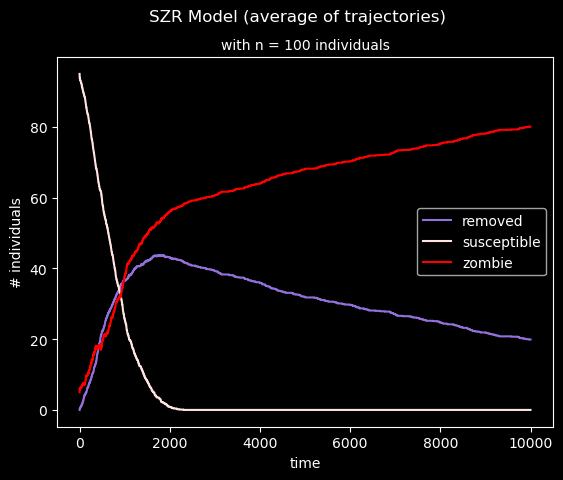

In [8]:
model = SZR_model(n = n, t = t,p_s = 0.95, p_z = 0.05)
results = run_stochastic_model(model, m, 'SZR Model', n, t=t)

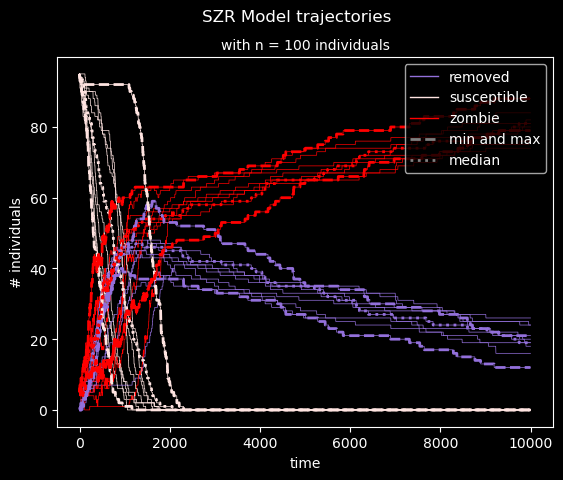

In [9]:
plot_model_trajectories(model, results, m, 'SZR Model', n)

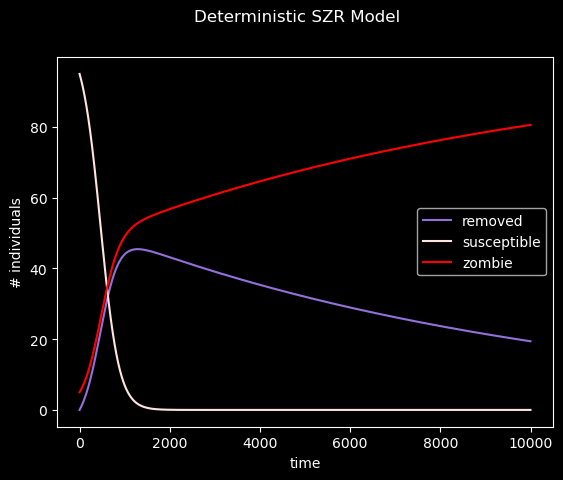

In [10]:
d_results = run_deterministic_model(model, 'SZR Model', n)

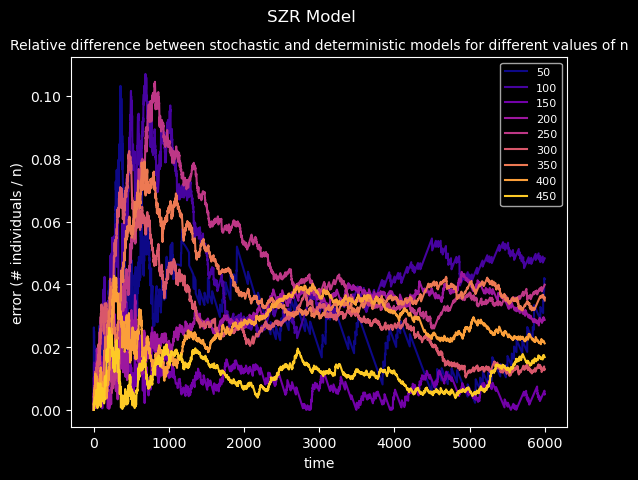

In [30]:
test_model_size(SZR_model, 500, 'SZR Model', t = t )

## Model with latent infection

We want to extend the basic model to include the (more ‘realistic’) possibility
that a susceptible individual becomes infected before succumbing to zombification:

The dynamics of this population are the following:

- Susceptibles first move to an infected class and remain there for some period of time before becoming zombies

Assuming that the timescale of the outbreak is short, we don't consider birth and death rates in the susceptibles or infected. So the differential equations become:

$$
\begin{cases}
S' = - \beta S Z \\
I' = \beta S Z - \rho I \\
Z' = \rho I + \zeta R - \alpha S Z \\
R' = \alpha S Z - \zeta R
\end{cases}
$$

In the stochastic population model, they are translated in the following reactions:

$$
\begin{cases}
S+Z \xrightarrow{\beta /N *S*Z} I+Z \\
S+Z \xrightarrow{\alpha /N *S*Z} S+R\\
I \xrightarrow{\rho*I} Z\\
R \xrightarrow{\zeta*R} Z
\end{cases}
$$


In [12]:
class SIZR_model(gillespy2.Model):
    
    #the initializer takes in input the size of the population, the timespan, the percentage of the susceptibles
    #and the percentage of the zombies
    def __init__(self, n = 100, t = 101, p_s = 0.9, p_z = 0.1):
        # First call the gillespy2.Model initializer.
        super().__init__(self)

        # Define variables for the species representing Susceptible(S), Zombie(Z), Removed(R), Infected(I)
        s = gillespy2.Species(name='susceptible', initial_value=n*p_s)
        z = gillespy2.Species(name='zombie',   initial_value=n*p_z)
        r = gillespy2.Species(name='removed',   initial_value=n*(1-(p_s+p_z)))
        i = gillespy2.Species(name='infected',   initial_value=0)
        self.add_species([s, z, r, i])
        
         # Define parameters for the rates of transmission (beta), removal (alpha), resurrection (zeta), zombiefication rate (ro)
        beta = gillespy2.Parameter(name='beta', expression=0.0095)
        alpha = gillespy2.Parameter(name='alpha', expression=0.005)
        zeta = gillespy2.Parameter(name='zeta', expression=0.0001)
        ro = gillespy2.Parameter(name='ro', expression=0.005)
        self.add_parameter([beta, alpha, zeta, ro])

        # The list of reactants and products for a Reaction object 
        s_i = gillespy2.Reaction(name="infection", reactants={s:1, z:1}, products={i:1, z:1}, propensity_function = "beta * susceptible * zombie  / (susceptible + zombie + removed)")
        z_r = gillespy2.Reaction(name="removal", propensity_function = "alpha * susceptible * zombie  / (susceptible + zombie + removed)",
                                 reactants={z:1, s:1}, products={r:1, s:1})
        r_z = gillespy2.Reaction(name="resurrection", propensity_function = "zeta * removed",
                                 reactants={r:1}, products={z:1})
        i_z = gillespy2.Reaction(name="zombiefication", propensity_function = "ro * infected",
                                 reactants={i:1}, products={z:1})
        self.add_reaction([s_i, z_r, r_z, i_z])

        # Set the timespan for the simulation.
        self.timespan(numpy.linspace(0, t-1, t))

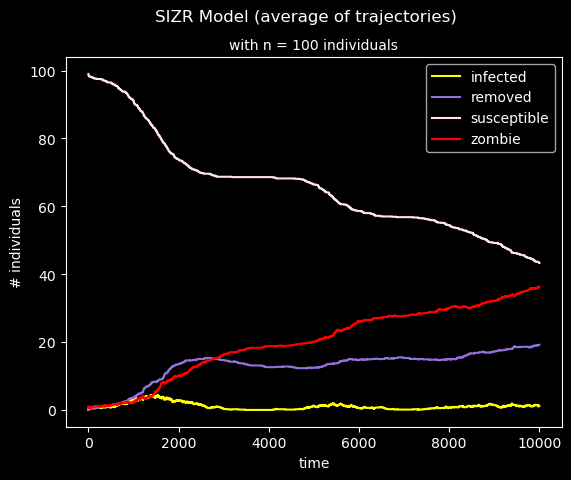

In [13]:
n = 100
colors = numpy.array(['yellow', 'mediumpurple', 'mistyrose','red'])
model = SIZR_model(n = n, t = t,p_s = 0.99, p_z = 0.01)
results = run_stochastic_model(model, m, 'SIZR Model', n, t=t)

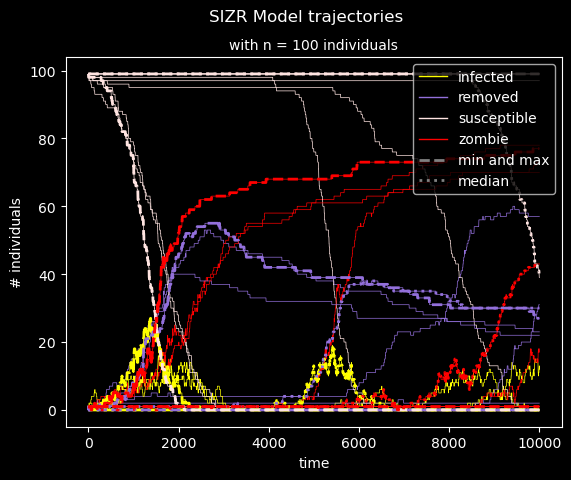

In [14]:
plot_model_trajectories(model, results, m, 'SIZR Model', n)

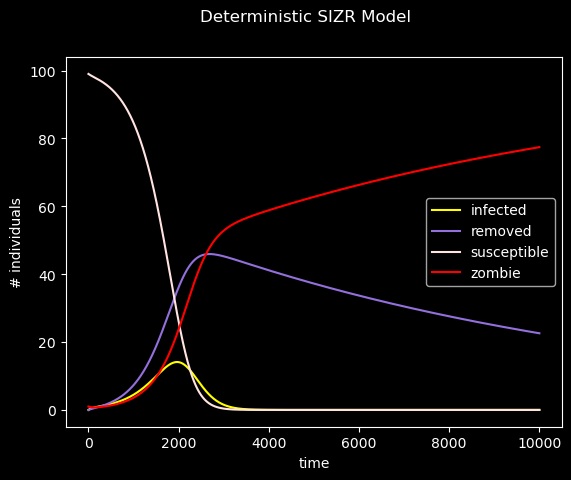

In [15]:
d_results = run_deterministic_model(model, 'SIZR Model', n)

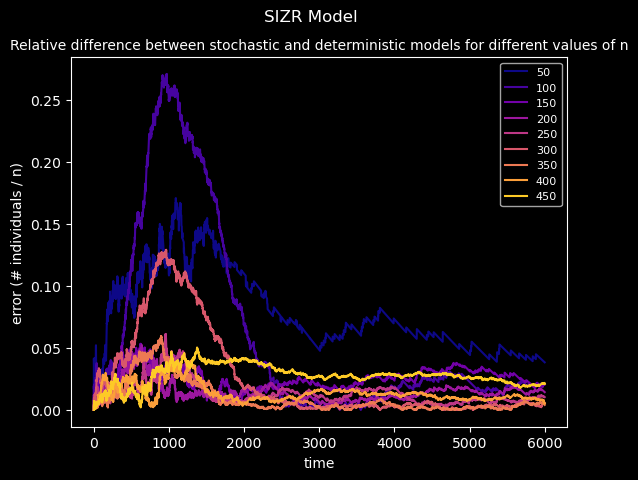

In [31]:
test_model_size(SIZR_model, 500, 'SIZR Model' , t = t)

## Model with quarantine

We assume that quarantined individuals
are removed from the population and cannot infect new individuals while they
remain quarantined.:

The dynamics of this population are the following:

- The quarantined area only contains members of the infected or zombie populations (entering at rates κ and σ, respectively)
- There is a chance some members will try to escape, but any that tried to would be killed (becoming part of the removed class) before finding their ‘freedom’ (parameter γ)


Assuming that the timescale of the outbreak is short, we don't consider birth and death rates in the susceptibles or infected. So the differential equations become:

$$
\begin{cases}
S' = - \beta S Z \\
I' = \beta S Z - \rho I - \kappa I\\
Z' = \rho I + \zeta R - \alpha S Z - \sigma Z \\
R' = \alpha S Z - \zeta R + \gamma Q\\
Q' = \kappa I + \sigma Z - \gamma Q
\end{cases}
$$

In the stochastic population model, they are translated in the following reactions:

$$
\begin{cases}
S+Z \xrightarrow{\beta / N *S*Z} I+Z \\
S+Z \xrightarrow{\alpha / N *S*Z} S+R\\
I \xrightarrow{\rho*I} Z\\
R \xrightarrow{\zeta*R} Z \\
Z \xrightarrow{\sigma*Z} Q \\
I \xrightarrow{\kappa*I} Q \\
Q \xrightarrow{\gamma*Q} R
\end{cases}
$$


In [17]:
#R0 = (beta*ro)/(ro+kappa)*alpha
#R0 > 1 => zombies win
#R0 < 1 => disease-free equilibrium is stable
#fixing beta, ro, alpha to the previous values, we have kappa = beta*ro/alpha - ro is the bifurcation value

class SIZRQ_model(gillespy2.Model):
    
    #the initializer takes in input the size of the population, the timespan, the percentage of the susceptibles
    #and the percentage of the zombies
    def __init__(self, n = 100, t = 101, p_s = 0.9, p_z = 0.1, k = 0.0045):
        # First call the gillespy2.Model initializer.
        super().__init__(self)

        # Define variables for the species representing Susceptible(S), Zombie(Z), Removed(R), Infected(I), Quarantined(Q)
        s = gillespy2.Species(name='susceptible', initial_value=n*p_s)
        z = gillespy2.Species(name='zombie',   initial_value=n*p_z)
        r = gillespy2.Species(name='removed',   initial_value=n*(1-(p_s+p_z)))
        i = gillespy2.Species(name='infected',   initial_value=0)
        q = gillespy2.Species(name='quarantined',   initial_value=0)
        self.add_species([s, z, r, i, q])
        
        # Define parameters for the rates of transmission (beta), removal (alpha), resurrection (zeta), zombiefication rate (ro),
        # infected quarantine (kappa), zombie quarantine (sigma), escape quarantine (gamma)
        beta = gillespy2.Parameter(name='beta', expression=0.0095)
        alpha = gillespy2.Parameter(name='alpha', expression=0.005)
        zeta = gillespy2.Parameter(name='zeta', expression=0.0001)
        ro = gillespy2.Parameter(name='ro', expression=0.005)
        kappa = gillespy2.Parameter(name='kappa', expression=k)
        sigma = gillespy2.Parameter(name='sigma', expression=k)
        gamma = gillespy2.Parameter(name='gamma', expression=k)
        self.add_parameter([beta, alpha, zeta, ro, kappa, sigma, gamma])

        # The list of reactants and products for a Reaction object 
        s_i = gillespy2.Reaction(name="infection", reactants={s:1, z:1}, products={i:1, z:1}, propensity_function = "beta * susceptible * zombie  / (susceptible + zombie + removed)")
        z_r = gillespy2.Reaction(name="removal", propensity_function = "alpha * susceptible * zombie  / (susceptible + zombie + removed)",
                                 reactants={z:1, s:1}, products={r:1, s:1})
        r_z = gillespy2.Reaction(name="resurrection", propensity_function = "zeta * removed",
                                 reactants={r:1}, products={z:1})
        i_z = gillespy2.Reaction(name="zombiefication", propensity_function = "ro * infected",
                                 reactants={i:1}, products={z:1})
        z_q = gillespy2.Reaction(name="zombie_quarantine", propensity_function = "sigma * zombie",
                                 reactants={z:1}, products={q:1})
        i_q = gillespy2.Reaction(name="infected_quarantine", propensity_function = "kappa * infected",
                                 reactants={i:1}, products={q:1})
        q_r = gillespy2.Reaction(name="escape_quarantine", propensity_function = "gamma * quarantined",
                                 reactants={q:1}, products={r:1})
        self.add_reaction([s_i, z_r, r_z, i_z, z_q, i_q, q_r])

        # Set the timespan for the simulation.
        self.timespan(numpy.linspace(0, t-1, t))

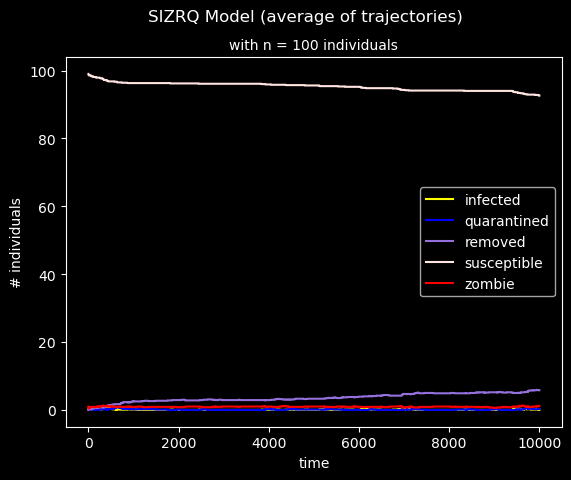

In [18]:
#k = 0.0045 implies R0 = 1 
n = 100
colors = numpy.array(['yellow', 'blue', 'mediumpurple', 'mistyrose','red'])
model = SIZRQ_model(n = n, t = t,p_s = 0.99, p_z = 0.01)
results = run_stochastic_model(model, m, 'SIZRQ Model', n, t=t)

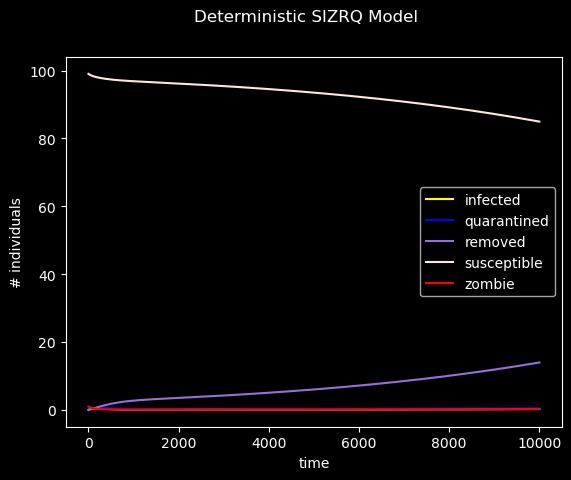

In [19]:
d_results = run_deterministic_model(model, 'SIZRQ Model', n)

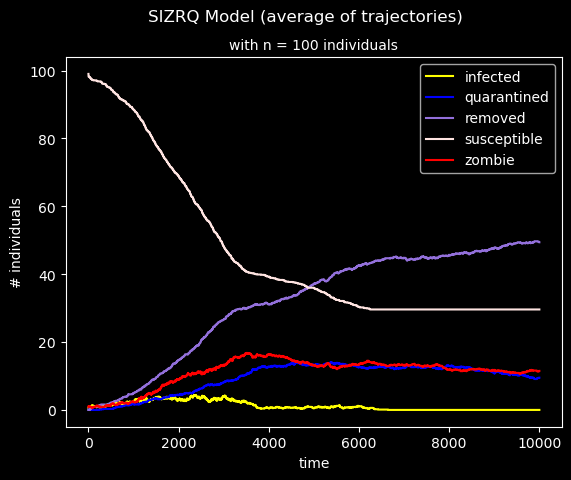

In [20]:
#now let's try with R0 > 1
model = SIZRQ_model(n = n, t = t,p_s = 0.99, p_z = 0.01, k = 0.0005)
results = run_stochastic_model(model, m, 'SIZRQ Model', n, t=t)

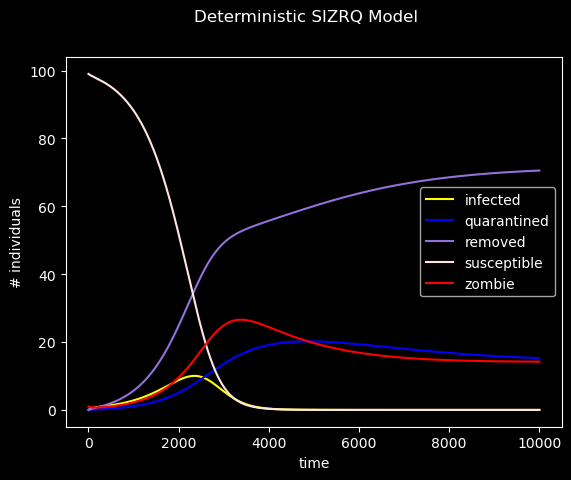

In [21]:
d_results = run_deterministic_model(model, 'SIZRQ Model', n)

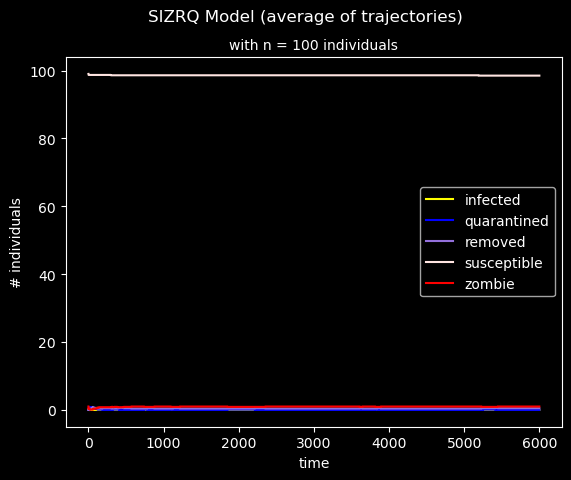

In [22]:
#now let's try with R0 < 1
t = 6000
model = SIZRQ_model(n = n, t = t,p_s = 0.99, p_z = 0.01, k = 0.01)
results = run_stochastic_model(model, m, 'SIZRQ Model', n, t=t)

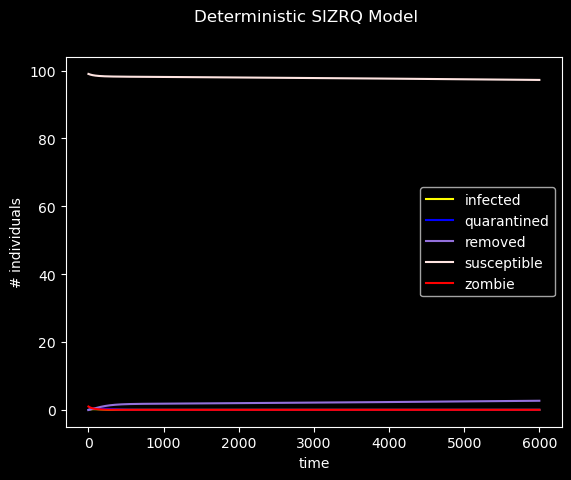

In [23]:
d_results = run_deterministic_model(model, 'SIZRQ Model', n)

## Model with treatment

We assume that a cure for ‘zombie-ism’ has been invented.

The dynamics of this population are the following:

- The cure will allow zombies to return to their original human form
- Any cured zombies become susceptible again; the cure does not provide immunity


Assuming that the timescale of the outbreak is short, we don't consider birth and death rates in the susceptibles or infected. So the differential equations become:

$$
\begin{cases}
S' = - \beta S Z + c Z \\
I' = \beta S Z - \rho I \\
Z' = \rho I + \zeta R - \alpha S Z - c Z\\
R' = \alpha S Z - \zeta R 
\end{cases}
$$

In the stochastic population model, they are translated in the following reactions:

$$
\begin{cases}
S+Z \xrightarrow{\beta / N *S*Z} I+Z \\
S+Z \xrightarrow{\alpha / N*S*Z} S+R\\
I \xrightarrow{\rho*I} Z\\
R \xrightarrow{\zeta*R} Z \\
Z \xrightarrow{c*Z} S
\end{cases}
$$


In [24]:
class SIZR_T_model(gillespy2.Model):
    
    #the initializer takes in input the size of the population, the timespan, the percentage of the susceptibles
    #and the percentage of the zombies
    def __init__(self, n = 100, t = 101, p_s = 0.9, p_z = 0.1):
        # First call the gillespy2.Model initializer.
        super().__init__(self)

        # Define variables for the species representing Susceptible(S), Zombie(Z), Removed(R), Infected(I)
        s = gillespy2.Species(name='susceptible', initial_value=n*p_s)
        z = gillespy2.Species(name='zombie',   initial_value=n*p_z)
        r = gillespy2.Species(name='removed',   initial_value=n*(1-(p_s+p_z)))
        i = gillespy2.Species(name='infected',   initial_value=0)
        self.add_species([s, z, r, i])
        
         # Define parameters for the rates of transmission (beta), removal (alpha), resurrection (zeta), zombiefication rate (ro), cure (c)
        beta = gillespy2.Parameter(name='beta', expression=0.0095)
        alpha = gillespy2.Parameter(name='alpha', expression=0.005)
        zeta = gillespy2.Parameter(name='zeta', expression=0.0001)
        ro = gillespy2.Parameter(name='ro', expression=0.005)
        c = gillespy2.Parameter(name='c', expression=0.0006)
        self.add_parameter([beta, alpha, zeta, ro, c])

        # The list of reactants and products for a Reaction object 
        s_i = gillespy2.Reaction(name="infection", reactants={s:1, z:1}, products={i:1, z:1}, propensity_function = "beta * susceptible * zombie  / (susceptible + zombie + removed)")
        z_r = gillespy2.Reaction(name="removal", propensity_function = "alpha * susceptible * zombie  / (susceptible + zombie + removed)",
                                 reactants={z:1, s:1}, products={r:1, s:1})
        r_z = gillespy2.Reaction(name="resurrection", propensity_function = "zeta * removed",
                                 reactants={r:1}, products={z:1})
        i_z = gillespy2.Reaction(name="zombiefication", propensity_function = "ro * infected",
                                 reactants={i:1}, products={z:1})
        z_s = gillespy2.Reaction(name="cure", propensity_function = "c * zombie",
                                 reactants={z:1}, products={s:1})
        self.add_reaction([s_i, z_r, r_z, i_z, z_s])

        # Set the timespan for the simulation.
        self.timespan(numpy.linspace(0, t-1, t))

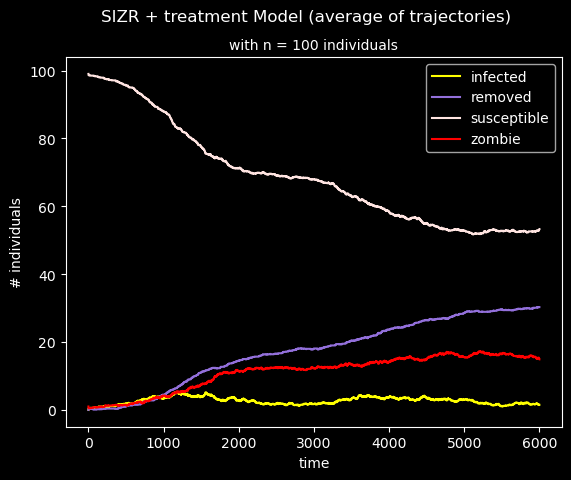

In [25]:
n = 100
colors = numpy.array(['yellow', 'mediumpurple', 'mistyrose','red'])
model = SIZR_T_model(n = n, t = t,p_s = 0.99, p_z = 0.01)
results = run_stochastic_model(model, m, 'SIZR + treatment Model', n, t=t)

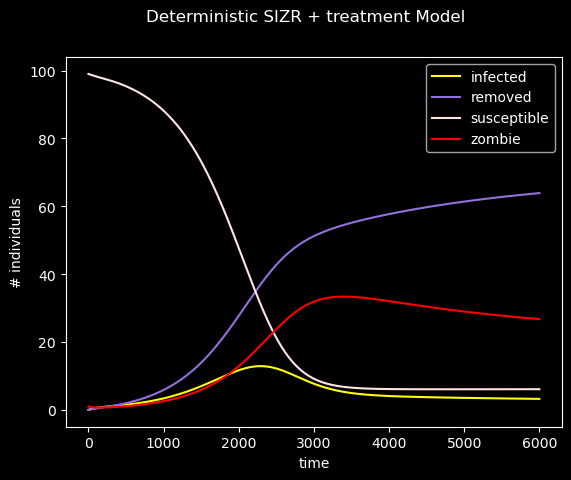

In [26]:
results_d = run_deterministic_model(model, 'SIZR + treatment Model', n)

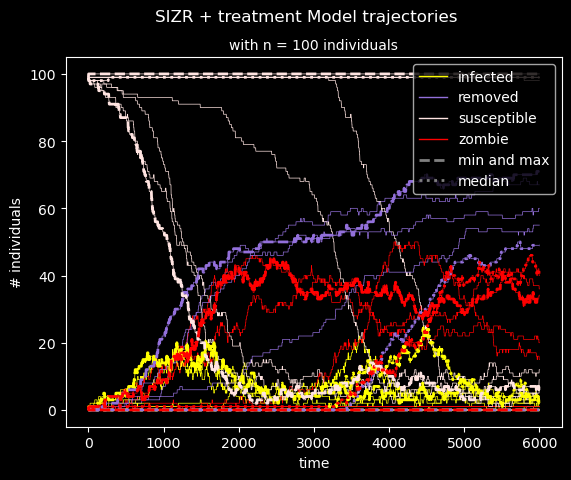

In [27]:
plot_model_trajectories(model, results, m, 'SIZR + treatment Model', n)

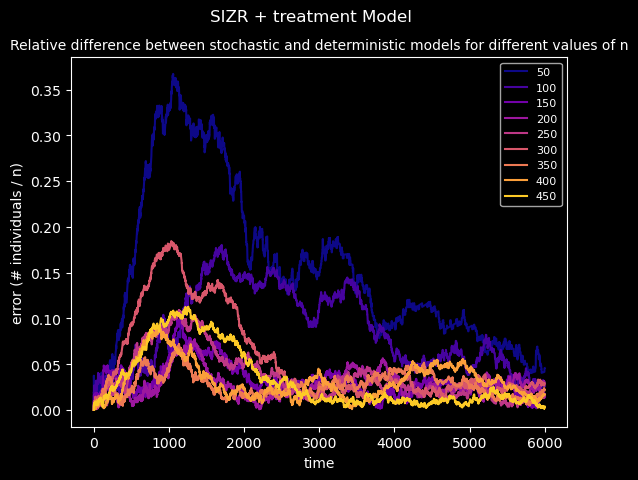

In [32]:
test_model_size(SIZR_T_model, 500, 'SIZR + treatment Model', t=t )